In [1]:
import sys
import os

# Use the virtual environment python instead
venv_path = r"F:/Research/Project/ai-powered-infant-monitoring-system/.venv/Scripts"
if venv_path not in sys.path:
    sys.path.insert(0, venv_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

print("✓ Core libraries imported successfully!")

✓ Core libraries imported successfully!


In [2]:
# === DATA LOADING ===

def load_image_biomarkers():
    """Load pre-extracted image biomarker data"""
    try:
        csv_path = "../data/processed/processed_pain_img_biomarkers.csv"
        
        if not os.path.exists(csv_path):
            # Try alternative path if running from different directory
            csv_path = "ml_pipeline/src/pain_discomfort/data/processed/processed_pain_img_biomarkers.csv"
            if not os.path.exists(csv_path):
                 raise FileNotFoundError(f"Cannot find data file")
        
        df = pd.read_csv(csv_path)
        
        # Available features in the dataset
        feature_cols = ["Edge_Density", "Contrast", "Brightness", "Texture_Variance", "Entropy", "Face_Size"]
        X = df[feature_cols].values
        y = df["Label"].values
        
        print(f"✓ Image biomarkers loaded successfully!")
        print(f"  - Samples: {len(X)}")
        print(f"  - Features: {feature_cols}")
        print(f"  - Classes: {np.unique(y)}")
        print(f"  - Distribution: {np.bincount(y)}")
        
        return X, y, df, feature_cols
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None, None, None, None

# Load the data
X, y, df, feature_cols = load_image_biomarkers()

if X is not None:
    print("\n✓ Data preparation complete!")
else:
    print("\n⚠ Failed to load data")

✓ Image biomarkers loaded successfully!
  - Samples: 503
  - Features: ['Edge_Density', 'Contrast', 'Brightness', 'Texture_Variance', 'Entropy', 'Face_Size']
  - Classes: [0 1 2]
  - Distribution: [184 103 216]

✓ Data preparation complete!


In [3]:
# === MODEL TRAINING ===
# Train a Random Forest Classifier

if X is not None and y is not None:
    # 1. Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"✓ Data Split:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")
    
    # 2. Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 3. Train Model (Random Forest)
    print("\nTraining Random Forest Classifier...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train_scaled, y_train)
    
    # 4. Cross-Validation (to validate on small dataset)
    cv_scores = cross_val_score(rf_model, scaler.transform(X), y, cv=5)
    print(f"  Cross-Validation Accuracy: {cv_scores.mean():.2%} (+/- {cv_scores.std()*2:.2%})")
    
    # 5. Save Model and Scaler
    model_dir = "../saved_models"
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(rf_model, os.path.join(model_dir, "pain_recognition_model.pkl"))
    joblib.dump(scaler, os.path.join(model_dir, "pain_scaler.pkl"))
    print(f"  ✓ Model saved to {model_dir}")
    
else:
    print("✗ Data not loaded - cannot train model")

✓ Data Split:
  Training samples: 402
  Test samples: 101

Training Random Forest Classifier...
  Cross-Validation Accuracy: 44.74% (+/- 9.60%)
  ✓ Model saved to ../saved_models
  Cross-Validation Accuracy: 44.74% (+/- 9.60%)
  ✓ Model saved to ../saved_models


✓ Classification Results:
  Test Accuracy: 50.50%

Classification Report:
              precision    recall  f1-score   support

        Calm       0.53      0.51      0.52        37
  Discomfort       0.50      0.10      0.16        21
 Severe Pain       0.49      0.70      0.58        43

    accuracy                           0.50       101
   macro avg       0.51      0.44      0.42       101
weighted avg       0.51      0.50      0.47       101



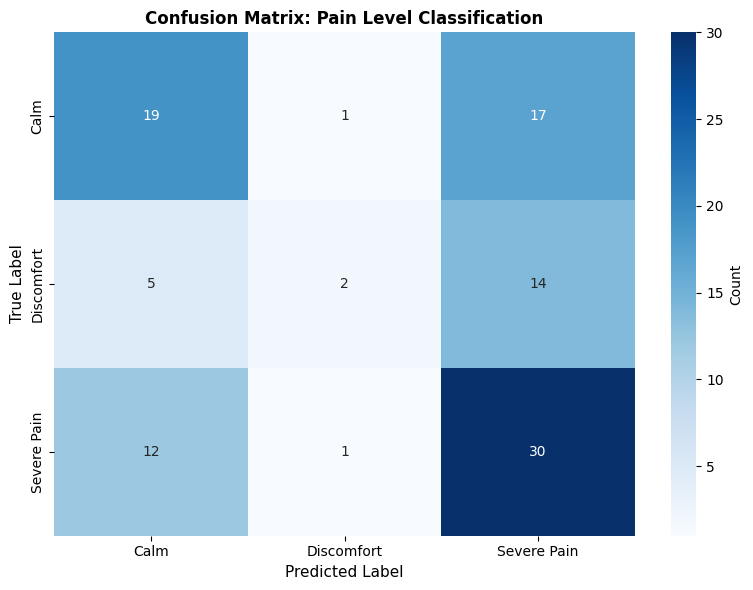


✓ Evaluation complete!


In [4]:
# === MODEL EVALUATION ===

if X is not None and y is not None:
    # Predictions
    y_pred = rf_model.predict(X_test_scaled)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Target names
    target_names = ["Calm", "Discomfort", "Severe Pain"]
    
    print(f"✓ Classification Results:")
    print(f"  Test Accuracy: {accuracy:.2%}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('True Label', fontsize=11)
    plt.title('Confusion Matrix: Pain Level Classification', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Evaluation complete!")

In [5]:
# === PREDICTION FUNCTION ===
# Use this to predict pain levels from new images

def predict_new_image(image_path):
    """
    Predict pain level from a new baby image using the trained model
    """
    try:
        # Load model and scaler
        model_path = "../saved_models/pain_recognition_model.pkl"
        scaler_path = "../saved_models/pain_scaler.pkl"
        
        if not os.path.exists(model_path) or not os.path.exists(scaler_path):
            return "Error: Model not found. Please train the model first."
            
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        # 1. Extract features
        img = cv2.imread(image_path)
        if img is None:
            return "Error: Could not load image"
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Extract biomarkers (simplified version for demo)
        # Note: Ideally import the exact extraction function from processing script
        features = {
            "Edge_Density": np.mean(cv2.Canny(gray, 100, 200)) / 255.0,
            "Contrast": np.std(gray) / 255.0,
            "Brightness": np.mean(gray) / 255.0,
            "Texture_Variance": np.var(gray) / (255**2),
            "Entropy": -np.sum(np.histogram(gray, bins=256)[0] / len(gray) * np.log2(np.histogram(gray, bins=256)[0] / len(gray) + 1e-10)),
            "Face_Size": img.shape[0] * img.shape[1]
        }
        
        # Ensure feature order matches training
        feature_cols = ["Edge_Density", "Contrast", "Brightness", "Texture_Variance", "Entropy", "Face_Size"]
        features_array = np.array([[features[col] for col in feature_cols]])
        
        # 2. Preprocess
        features_scaled = scaler.transform(features_array)
        
        # 3. Predict
        prediction = model.predict(features_scaled)[0]
        probabilities = model.predict_proba(features_scaled)[0]
        confidence = probabilities[prediction]
        
        classes = ["Calm 😌", "Discomfort 😐", "Severe Pain 😫"]
        
        print(f"\n✓ Prediction Result:")
        print(f"  Class: {classes[prediction]}")
        print(f"  Confidence: {confidence*100:.1f}%")
        print(f"  Probabilities: {probabilities}")
        
        # Display image
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Prediction: {classes[prediction]} ({confidence*100:.0f}%)")
        plt.tight_layout()
        plt.show()
        
        return {"class": int(prediction), "name": classes[prediction], "confidence": float(confidence)}
        
    except Exception as e:
        print(f"✗ Error: {e}")
        return {"error": str(e)}

# Example usage:
print("Function defined: predict_new_image(image_path)")

Function defined: predict_new_image(image_path)
